The aim of this notebook is to test the LM distance minimization procedure on real image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


## Segmentation


In [2]:
brigthfield_path = '../../../assets/sample_image_actin_surligned.tif'
#dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '../../../assets/sample_image_dapi.tiff'
scp_path = '../../../assets/star_convex_polynoms/models'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)
Nf = organo.Nf
geom.update_all(organo)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
normalize_scale(organo, geom)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01


Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


{'geometry': 'planar', 'R_in': 119.94799383544922, 'R_out': 134.21666275024415, 'R_vit': None}
0.9999999950313019


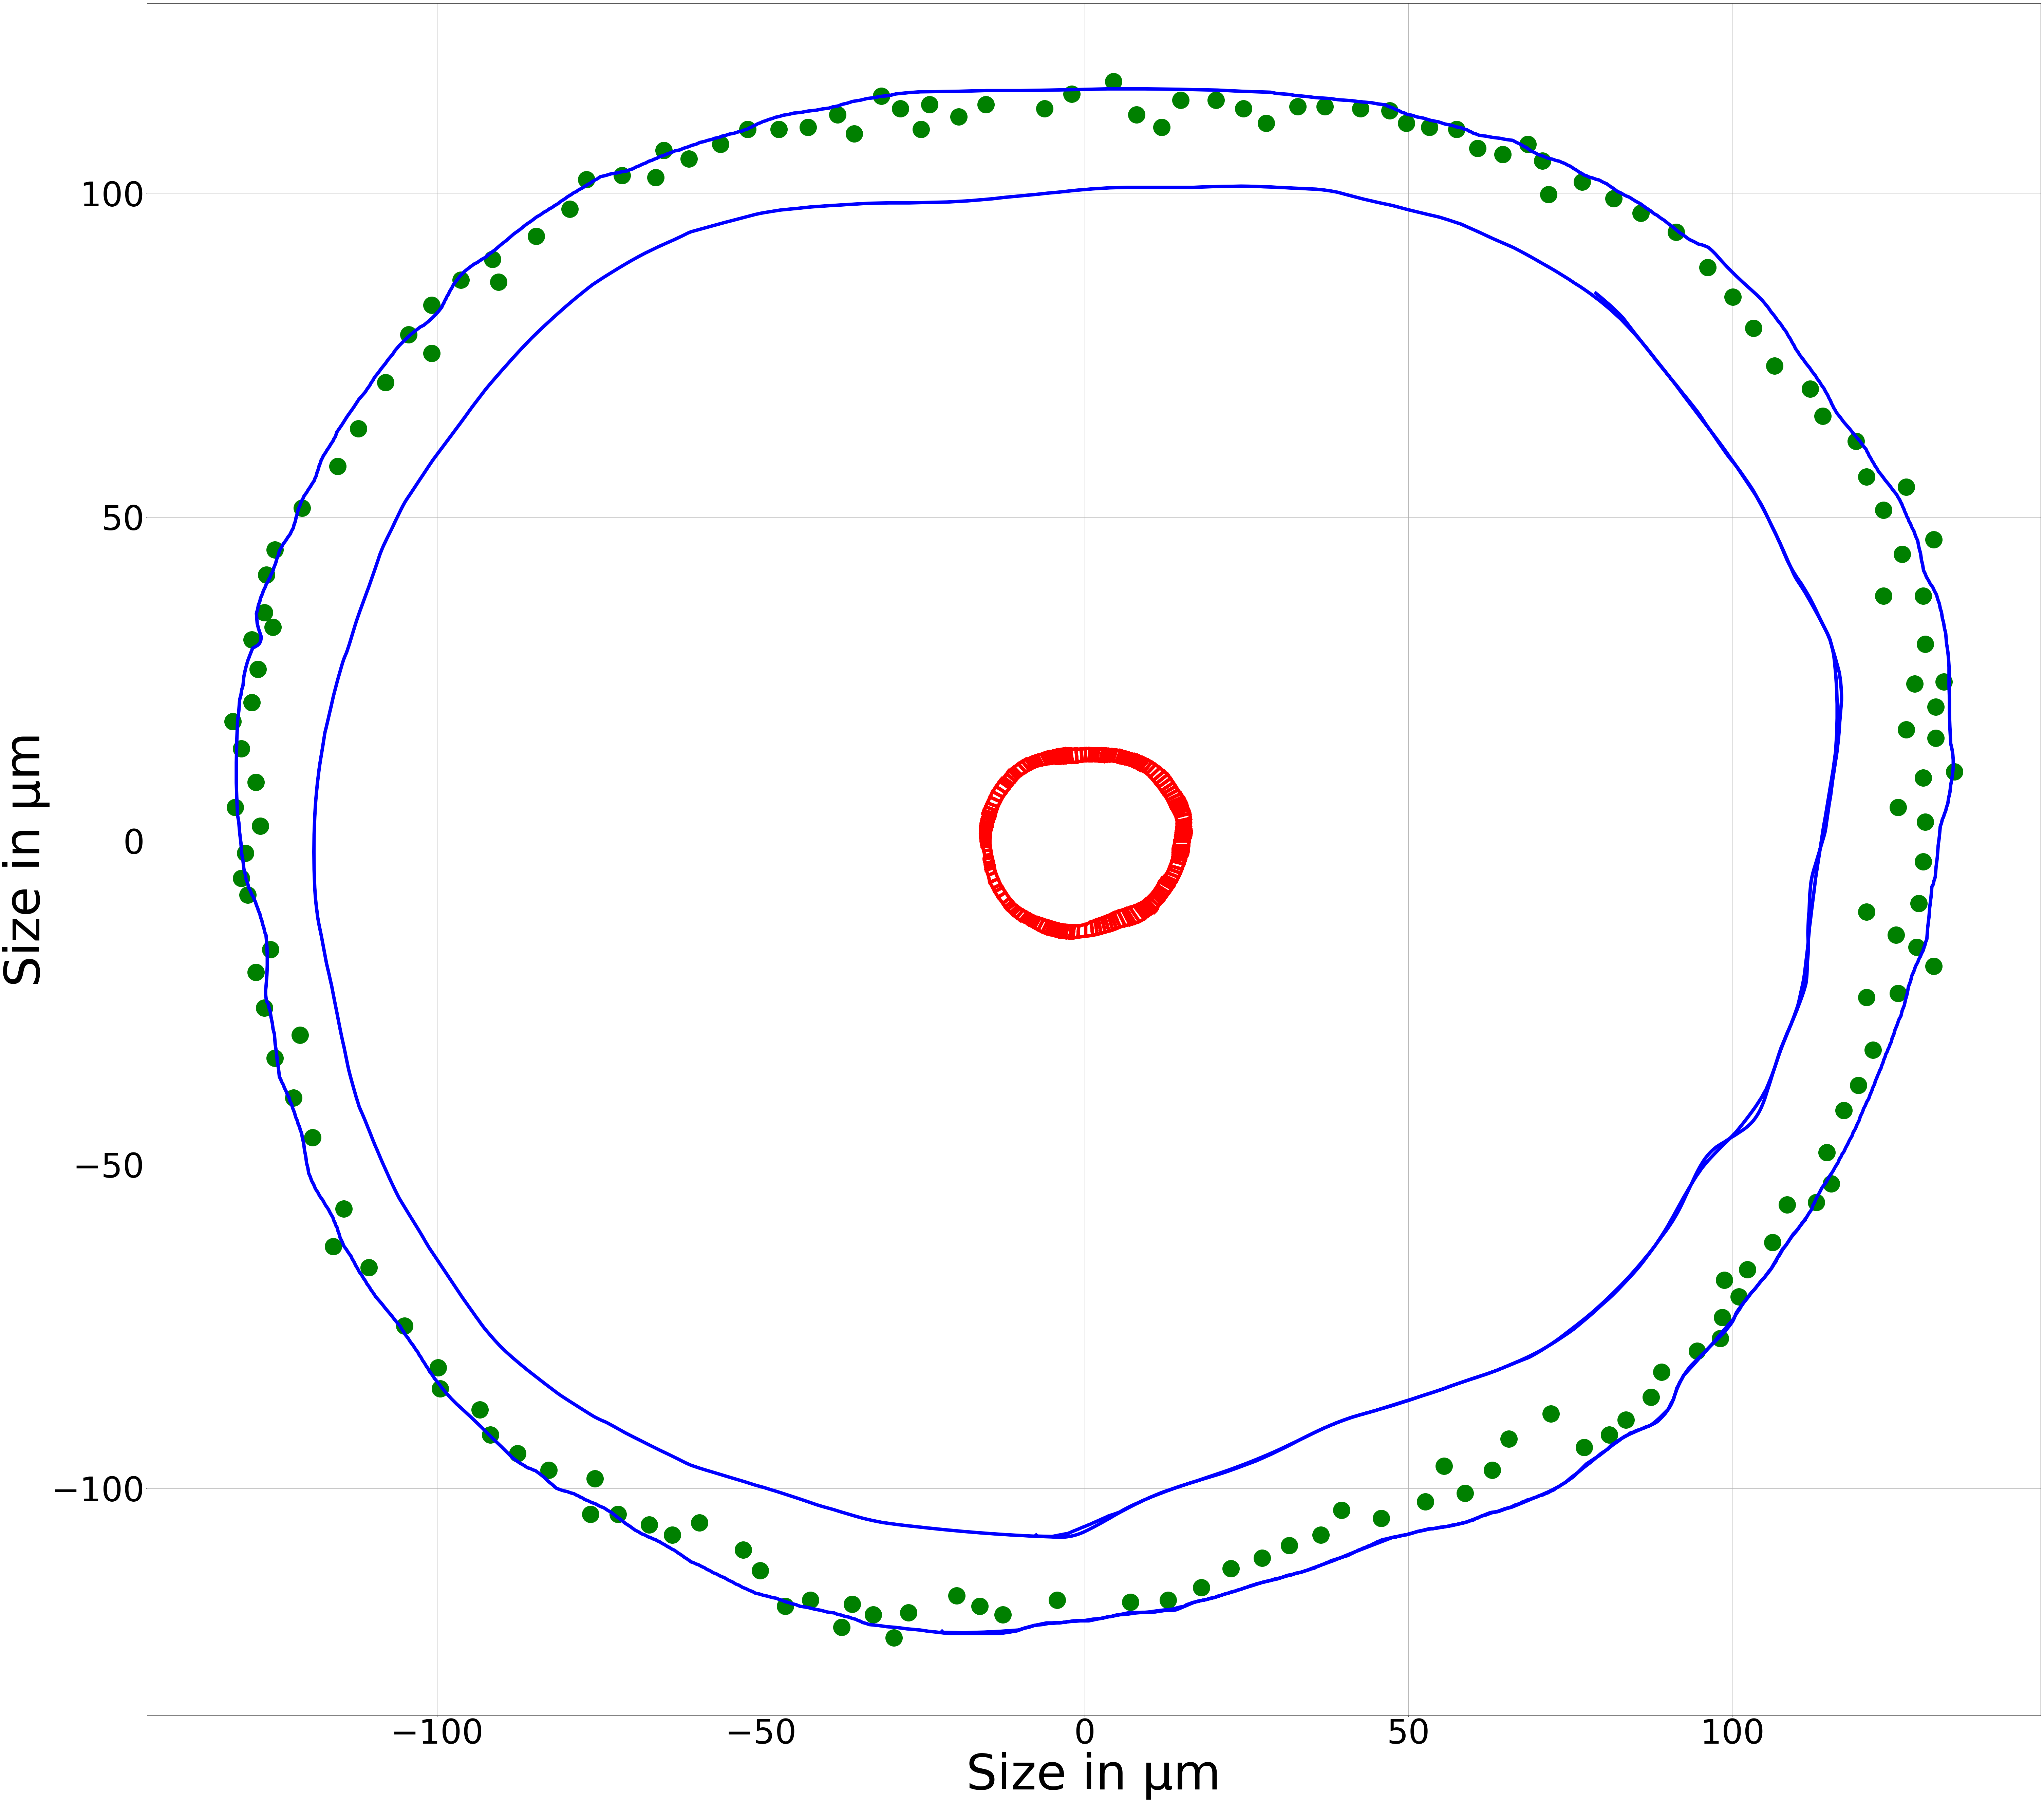

In [3]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

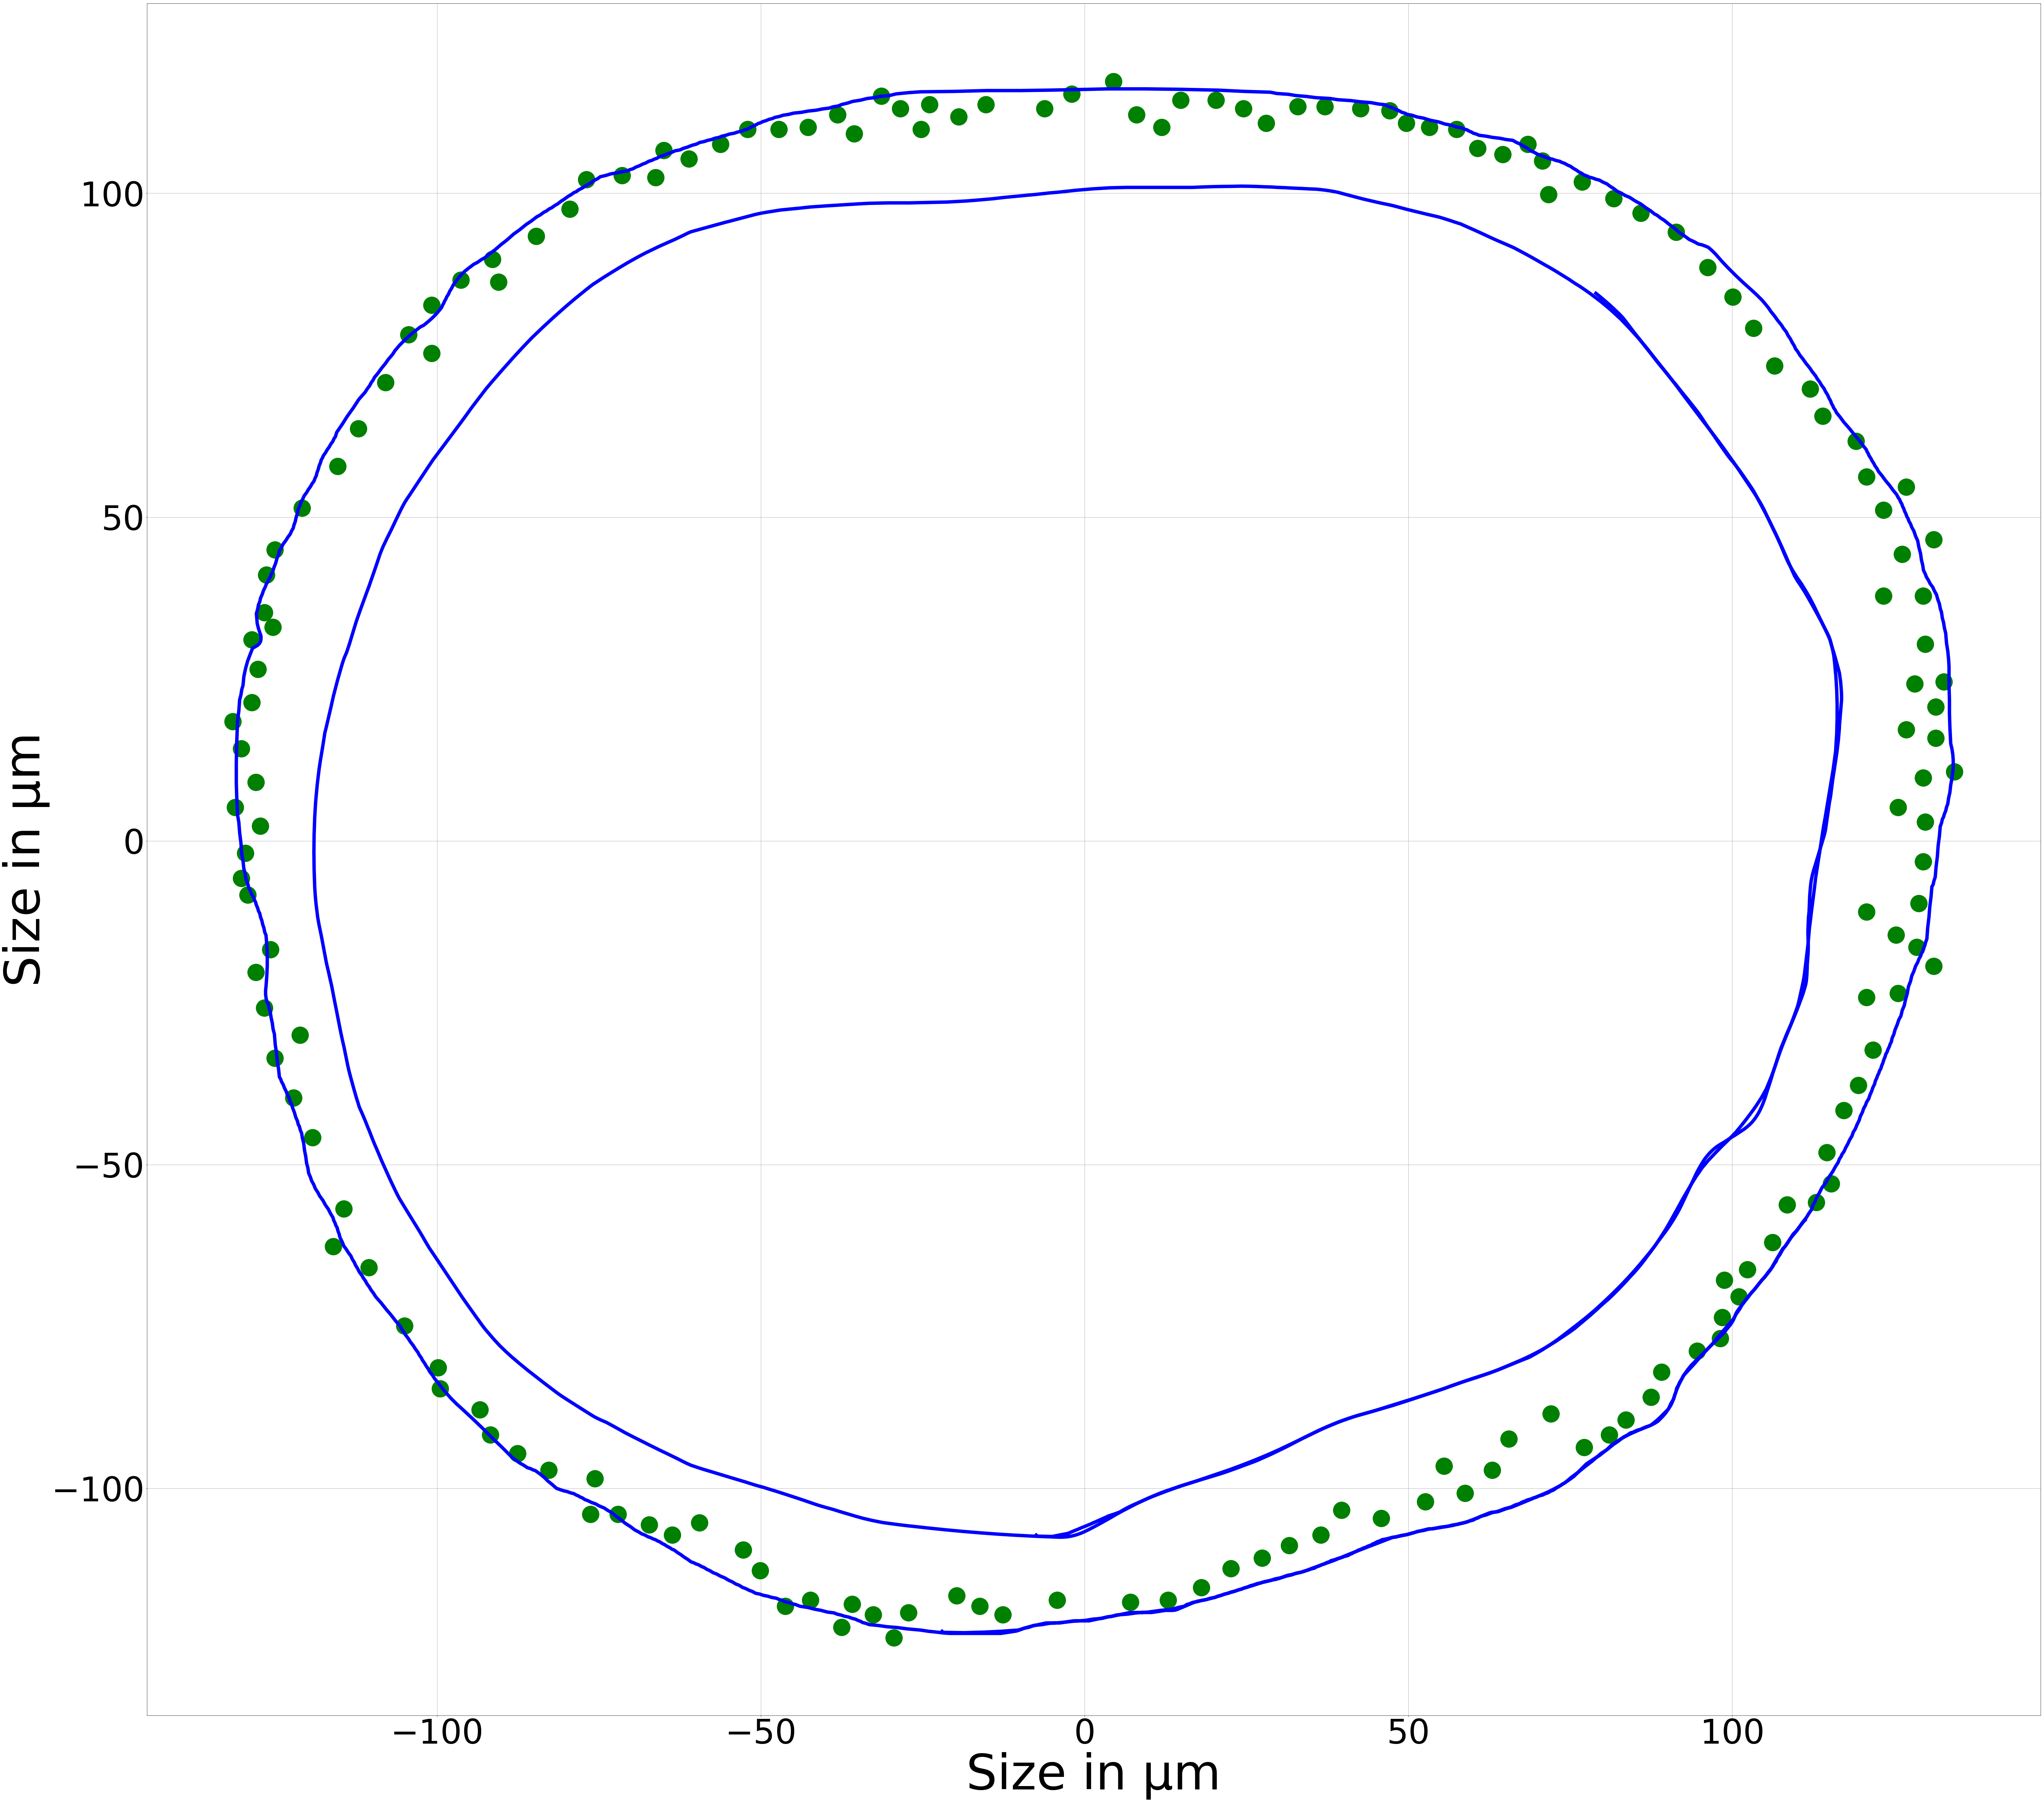

In [4]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

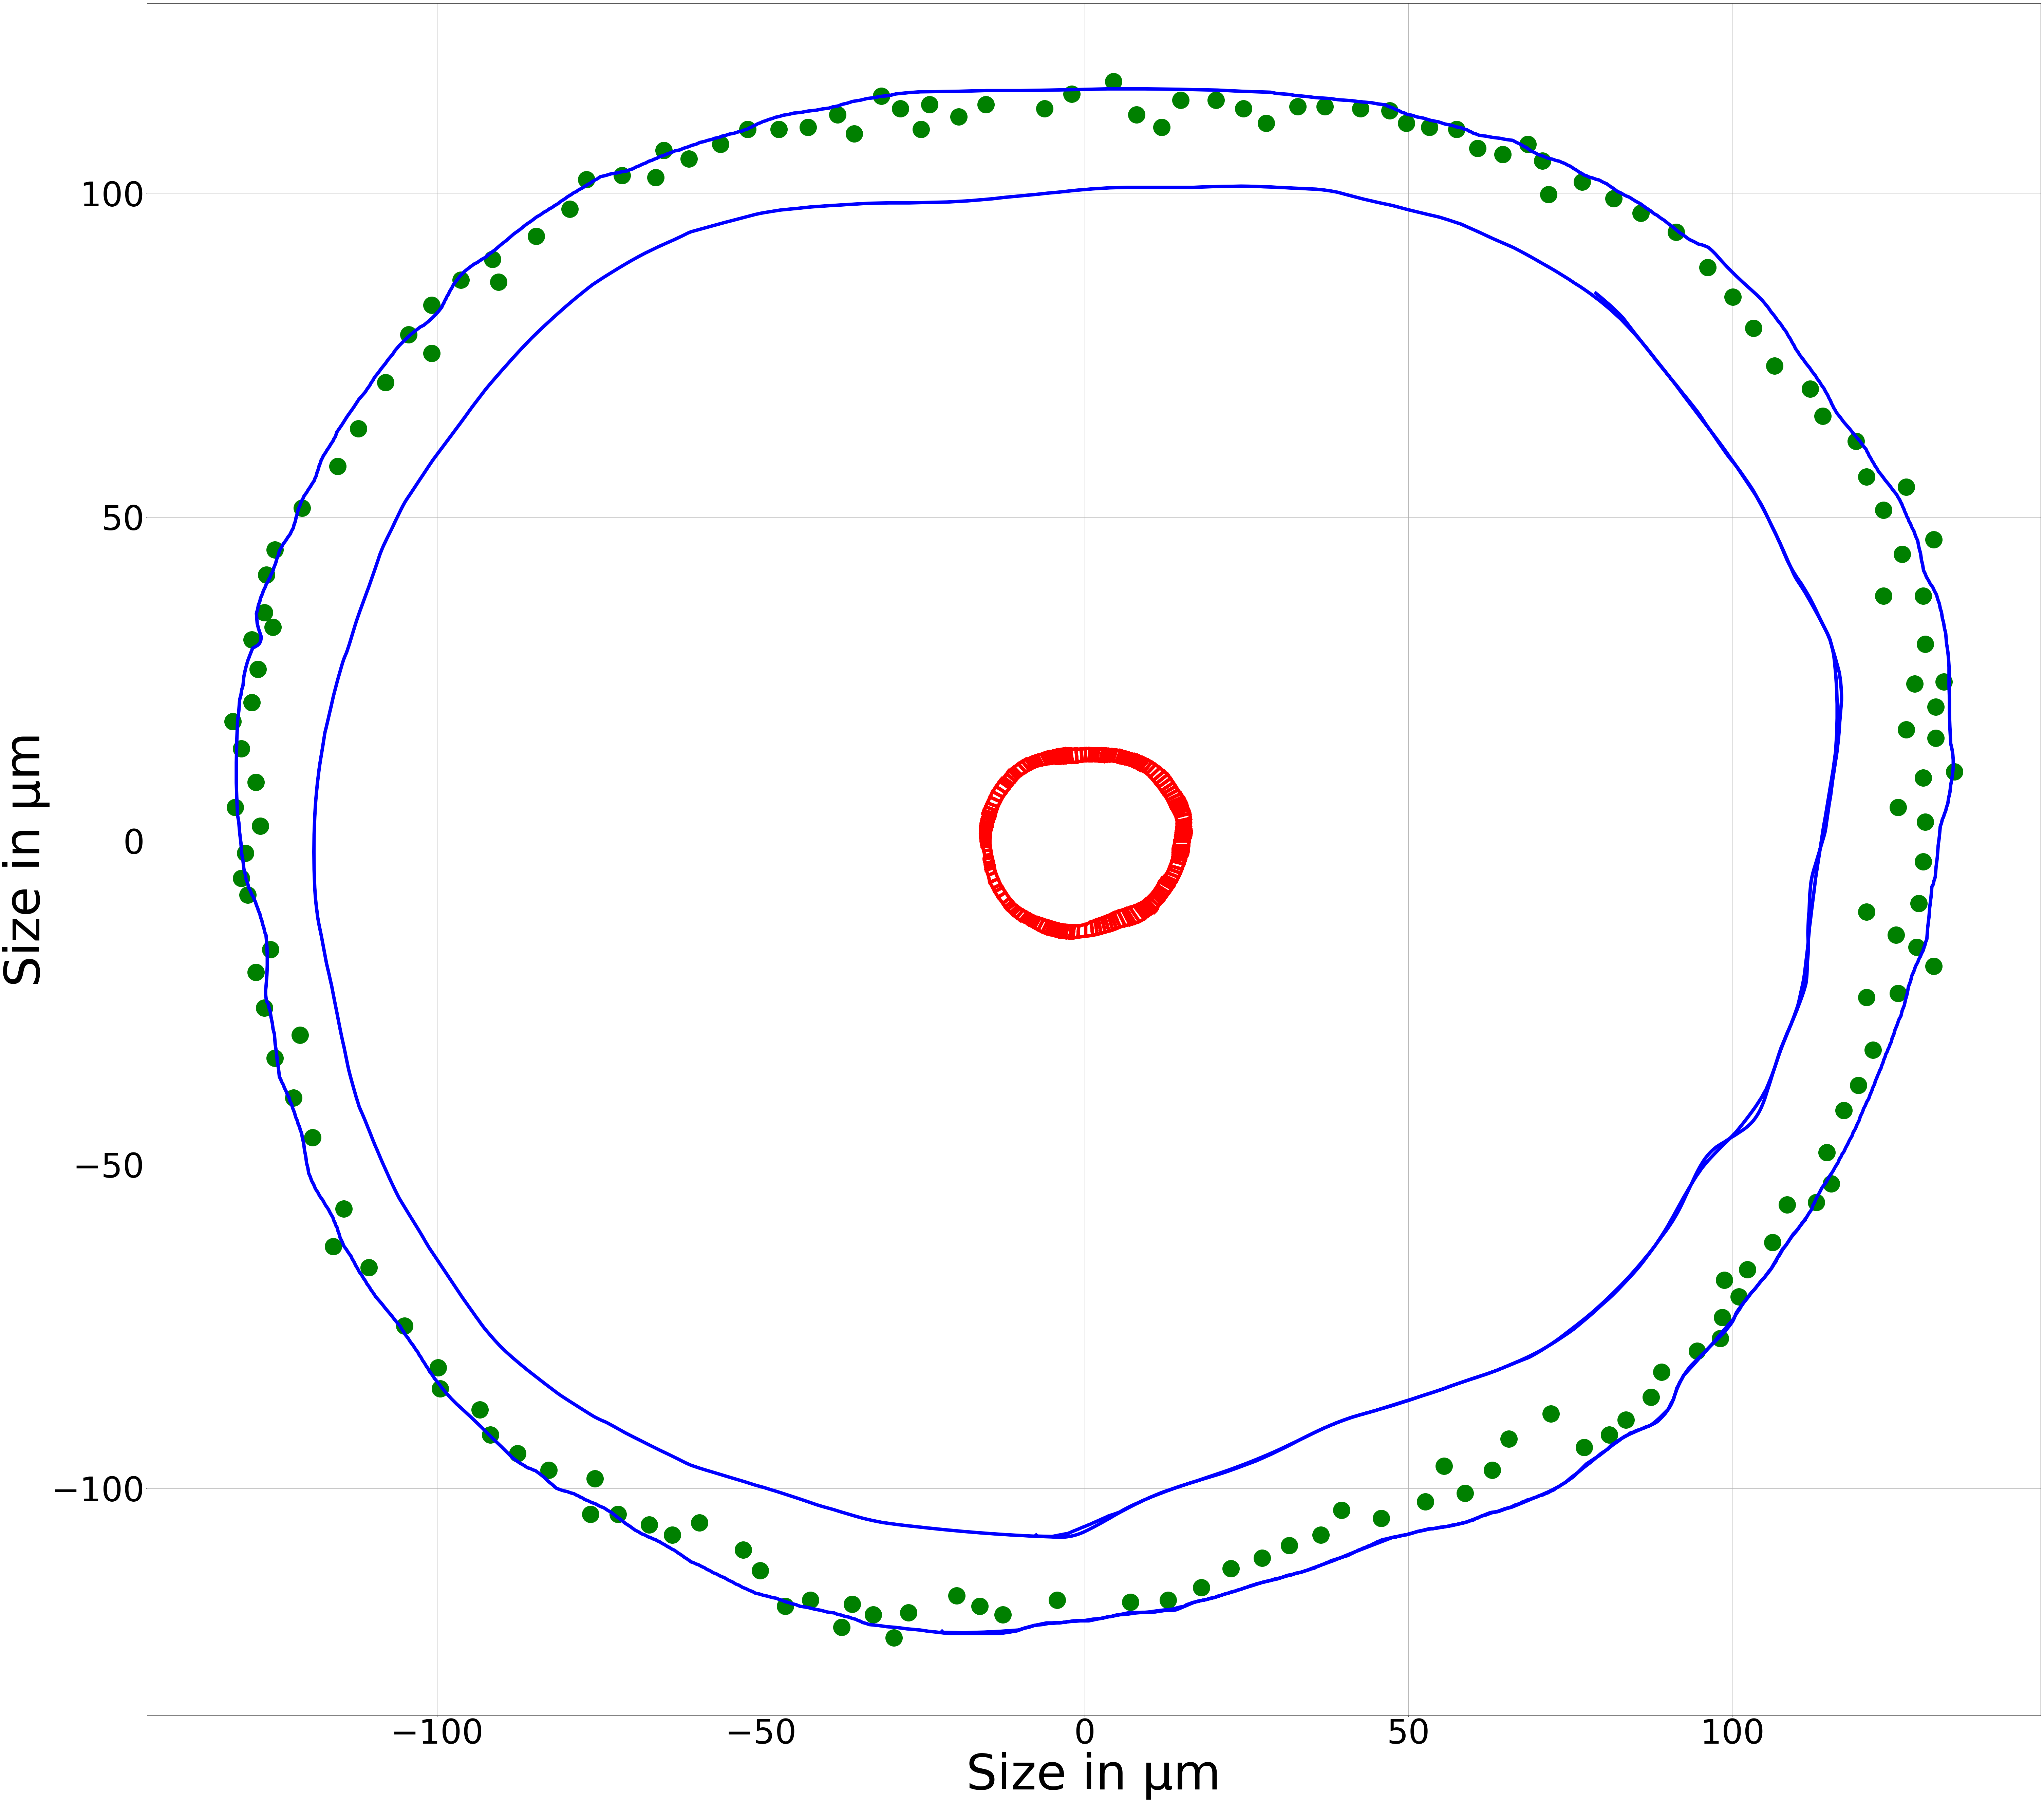

In [5]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

Creating a printing function

In [6]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

Define the optimization parameters

In [7]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-8,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-7,'ftol': 1e-6, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

## Force inference

In [8]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.01):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

In [9]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

In [10]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(organo.Nf,
                                                  organo.settings['R_in'],
                                                  organo.settings['R_out']))

In [21]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (organo.settings['R_out']-organo.settings['R_in'])*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.95693172, 0.94232203, 0.94547194, 0.95858202, 0.96833792,
       0.9648219 , 0.91607392, 0.85245031, 0.80282889, 0.77572843,
       0.74689122, 0.73455372, 0.76503627, 0.77568011, 0.74695913,
       0.7138449 , 0.7060971 , 0.68668743, 0.667607  , 0.77223273,
       0.71364921, 0.66963075, 0.71233387, 0.75011691, 0.637165  ,
       0.63926996, 0.63303069, 0.64547174, 0.59256778, 0.5841828 ,
       0.616935  , 0.63340362, 0.65084187, 0.67714867, 0.71492676,
       0.75004673, 0.79005016, 0.8337358 , 0.85660728, 0.87035794,
       0.87652863, 0.90518726, 0.93586089, 0.91716886, 0.87918212,
       0.8638491 , 0.88470231, 0.91139483, 0.91125517, 0.90822272,
       0.86054048, 0.84655011, 0.85550326, 0.84336572, 0.82600268,
       0.83246584, 0.84701109, 0.84902142, 0.81567255, 0.79344111,
       0.79803644, 0.82439882, 0.86254302, 0.89941738, 0.94820363,
       1.0266123 , 1.04023913, 1.08902115, 1.1329334 , 1.09416166,
       1.09408824, 1.10747654, 1.11939874, 1.0692942 , 0.95281

In [23]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (organo.settings['R_out']-organo.settings['R_in'])*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    coef_dir = (coord_api_vertex[1, 1] - coord_api_vertex[0, 1])/(coord_api_vertex[1, 0] - coord_api_vertex[0, 0])
    polar_coefs[cell] = (abs(coef_dir * coord_cell_center[0] -
                             coord_cell_center[1] +
                             (coord_api_vertex[0, 1] - coef_dir * coord_api_vertex[0, 0])) /
                         (coef_dir**2+1)**2)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([9.03768673e-01, 8.76363353e-01, 8.36713890e-01, 8.44120781e-01,
       8.44917929e-01, 8.21533372e-01, 8.09932545e-01, 7.36537252e-01,
       6.91701017e-01, 6.33568976e-01, 5.21091833e-01, 4.65952342e-01,
       5.16632029e-01, 4.92744085e-01, 4.46312190e-01, 3.35598200e-01,
       3.23112647e-01, 2.02679757e-01, 1.66823233e-01, 1.19272022e-01,
       9.78973925e-02, 9.79016624e-02, 4.48985142e-02, 3.15798349e-02,
       9.65135116e-03, 3.13610776e-03, 4.27540691e-03, 7.87733449e-03,
       8.26407078e-03, 2.22678494e-03, 1.97757195e-03, 9.26271223e-04,
       5.33516918e-08, 4.92010176e-04, 1.48475875e-05, 1.36836948e-03,
       8.35681594e-03, 1.31734923e-02, 7.92112361e-03, 1.43529661e-02,
       4.88103862e-02, 2.88459691e-02, 1.02513495e-02, 2.50740546e-02,
       3.26143330e-02, 6.36447892e-02, 1.03816247e-01, 1.76233191e-01,
       1.87655640e-01, 2.03670294e-01, 1.83850969e-01, 2.66665541e-01,
       1.78047671e-01, 3.00773937e-01, 3.98870430e-01, 4.77669151e-01,
      

[0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.016865368034769145, 0.0168653

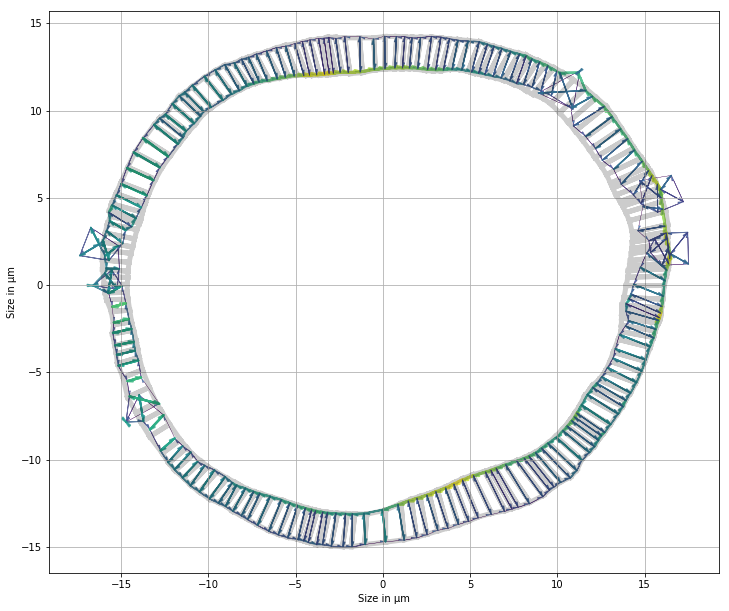

In [24]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
#avg_cste = [2.44/(3*organo.Nf)*4]*organo.Nf
print(avg_cste)
#avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
#area_ela_line = np.concatenate((np.zeros(organo.Nf*3),
#                                np.ones(organo.Nf),
#                                [0]))
#matrix = np.vstack((matrix, area_ela_line))
#constant = np.concatenate((constant, [-params_in_sym_mesh[0]*organo.Nf]))
print(params_in_sym_mesh[0]*organo.Nf)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

Distance from th organo to exp organo : 14.765533020747696
Distance from th tensions to exp tensions : 2.16310635520169


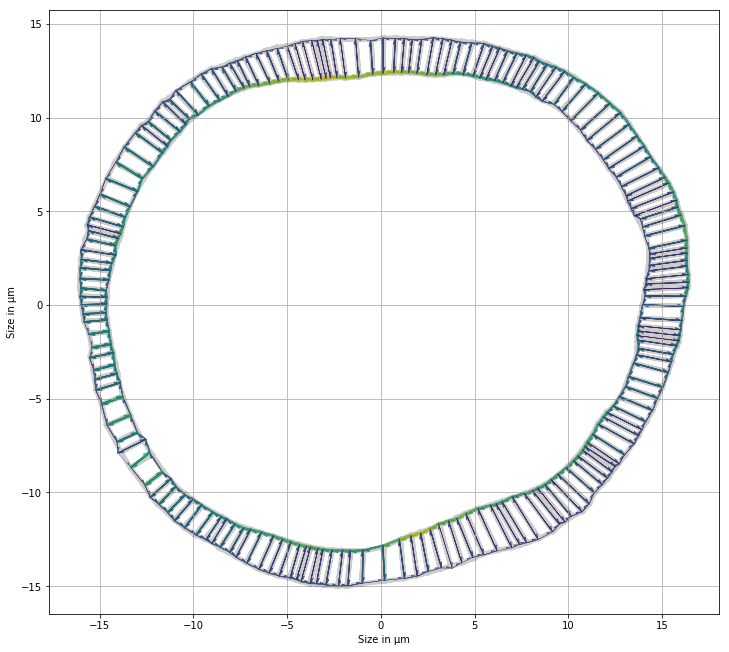

In [15]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

## Starting the optimization procedure

Sixth try : initial point obtained with NNLS computing only tensions, with the star convex polygons nuclei detection and moving average window equal to 100.

In [13]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../../assets/dist_at_each_f_ev/20_03_real_img.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005487836452456 [0.0728184  0.07958255 0.09375021 ... 0.         0.         0.        ]
21.00548484505611 [0.07281836 0.07958255 0.09375017 ... 0.         0.         0.        ]
21.005484611557108 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548194335926 [0.07281833 0.07958252 0.09375015 ... 0.         0.         0.        ]
21.005485942217586 [0.07281837 0.07958255 0.09375019 ... 0.         0.         0.        ]
21.005489035343853 [0.0728184  0.07958256 0.09375022 ... 0.         0.         0.        ]
21.005481554523854 [0.07281833 0.07958252 0.09375015 ... 0.         0.         0.        ]
21.005483702242156 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.0

21.00548765151465 [0.07281839 0.07958256 0.09375021 ... 0.         0.         0.        ]
21.005484496602314 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005481420497187 [0.07281833 0.07958252 0.09375014 ... 0.         0.         0.        ]
21.005486126293555 [0.07281837 0.07958255 0.09375019 ... 0.         0.         0.        ]
21.005492090080203 [0.07281843 0.07958258 0.09375025 ... 0.         0.         0.        ]
21.005477389001275 [0.07281829 0.07958249 0.0937501  ... 0.         0.         0.        ]
21.00548654736417 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.00548651227396 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.00548530491783 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005483790712447 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.005484786076597 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.

21.00548704202613 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.005483594053928 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.00548365194844 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.005487338132536 [0.07281838 0.07958255 0.09375021 ... 0.         0.         0.        ]
21.00548442285279 [0.07281836 0.07958254 0.09375017 ... 0.         0.         0.        ]
21.00548421400672 [0.07281835 0.07958254 0.09375017 ... 0.         0.         0.        ]
21.005484653891408 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005487550575474 [0.07281839 0.07958255 0.09375021 ... 0.         0.         0.        ]
21.005481048611685 [0.07281832 0.07958252 0.09375014 ... 0.         0.         0.        ]
21.005486610335137 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.005486755963844 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.

21.00548240672887 [0.07281834 0.07958252 0.09375015 ... 0.         0.         0.        ]
21.005489190950765 [0.0728184  0.07958256 0.09375022 ... 0.         0.         0.        ]
21.005486068733553 [0.07281838 0.07958255 0.09375019 ... 0.         0.         0.        ]
21.005483424730777 [0.07281834 0.07958253 0.09375016 ... 0.         0.         0.        ]
21.005485267558704 [0.07281837 0.07958254 0.09375019 ... 0.         0.         0.        ]
21.005488996940016 [0.0728184  0.07958256 0.09375022 ... 0.         0.         0.        ]
21.005479268018053 [0.07281831 0.07958251 0.09375012 ... 0.         0.         0.        ]
21.005485780062678 [0.07281837 0.07958255 0.09375019 ... 0.         0.         0.        ]
21.005483006419144 [0.07281834 0.07958252 0.09375016 ... 0.         0.         0.        ]
21.005490170067947 [0.07281842 0.07958258 0.09375023 ... 0.         0.         0.        ]
21.005485527278378 [0.07281836 0.07958254 0.09375019 ... 0.         0.         0.        ]


21.005484477653187 [0.07281835 0.07958254 0.09375017 ... 0.         0.         0.        ]
21.005487714012403 [0.07281838 0.07958255 0.09375021 ... 0.         0.         0.        ]
21.00549557145646 [0.07281846 0.0795826  0.09375029 ... 0.         0.         0.        ]
21.00549476774043 [0.07281846 0.0795826  0.09375028 ... 0.         0.         0.        ]
21.005490116762182 [0.07281841 0.07958257 0.09375023 ... 0.         0.         0.        ]
21.005487402299835 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.005487299098565 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.00548529745574 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005484300012593 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.005487148127088 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.005492660298437 [0.07281844 0.07958258 0.09375026 ... 0.         0.         0.        ]
21

21.005484194289377 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.00548194773252 [0.07281833 0.07958252 0.09375015 ... 0.         0.         0.        ]
21.005483181912 [0.07281834 0.07958253 0.09375016 ... 0.         0.         0.        ]
21.005483651608117 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.005484001745952 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.005485090766044 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.0054851186256 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548401168693 [0.07281835 0.07958253 0.09375017 ... 0.         0.         0.        ]
21.00548307493687 [0.07281834 0.07958253 0.09375016 ... 0.         0.         0.        ]
21.00548449446869 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.005486359340143 [0.07281838 0.07958255 0.0937502  ... 0.         0.         0.        ]
21.00548

21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.0054849

21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.00548498802821 [0.07281836 0.07958254 0.09375018 ... 0.         0.         0.        ]
21.0054849

21.00220848993978 [0.0727853  0.07956338 0.09371567 ... 0.         0.         0.        ]
21.0111352830196 [0.07287332 0.07961577 0.09380787 ... 0.         0.         0.        ]
21.004156738948243 [0.07280567 0.07957485 0.09373671 ... 0.         0.         0.        ]
21.004746253285173 [0.07281125 0.07957815 0.09374272 ... 0.         0.         0.        ]
21.00201599264437 [0.07278301 0.07956199 0.09371353 ... 0.         0.         0.        ]
21.004513890227575 [0.07280892 0.0795768  0.09374027 ... 0.         0.         0.        ]
21.011071657439725 [0.07287254 0.07961531 0.09380713 ... 0.         0.         0.        ]
21.001276913267098 [0.07277538 0.07955785 0.0937055  ... 0.         0.         0.        ]
21.005367296463124 [0.07281757 0.07958203 0.09374914 ... 0.         0.         0.        ]
21.012372123156872 [0.07288546 0.07962331 0.09382041 ... 0.         0.         0.        ]
21.002584182505014 [0.0727892 0.0795656 0.0937197 ... 0.        0.        0.       ]
21.004820

21.00300632009558 [0.07279322 0.07956822 0.09372388 ... 0.         0.         0.        ]
21.00890556296821 [0.07285239 0.07960294 0.09378555 ... 0.         0.         0.        ]
21.01003768229937 [0.07286198 0.07960927 0.09379622 ... 0.         0.         0.        ]
20.999450289203722 [0.07275606 0.07954704 0.09368561 ... 0.         0.         0.        ]
21.00584003809018 [0.07282065 0.07958434 0.09375309 ... 0.         0.         0.        ]
21.012038056856774 [0.0728834  0.07962147 0.09381782 ... 0.         0.         0.        ]
21.009591554818027 [0.07285821 0.07960657 0.09379214 ... 0.         0.         0.        ]
21.003370045412105 [0.07279747 0.07957024 0.09372822 ... 0.         0.         0.        ]
21.00618470133208 [0.07282514 0.0795866  0.09375735 ... 0.         0.         0.        ]
21.00613356978271 [0.07282451 0.07958627 0.09375673 ... 0.         0.         0.        ]
21.004326637379194 [0.07280658 0.07957564 0.09373799 ... 0.         0.         0.        ]
21.00

13.799018848502696 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018796961002 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018864682635 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018894286007 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.79901885639565 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018875772166 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901885077591 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018862715027 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018859967315 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018825555812 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901884884691 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13

13.799018877950518 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.799018792973609 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018864377015 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018897701638 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.799018831620225 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018839514659 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018968048328 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.799018671089865 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799019160976146 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.79901841597596 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799019364290238 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]


13.799018836406901 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901884773544 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018846492048 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799024641433551 [0.01801314 0.02282653 0.01975632 ... 0.         0.         0.        ]
13.799018847662133 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018848349812 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018844969169 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018846428268 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018846871702 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018848851047 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901884757145 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
1

13.799018778433496 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018870748167 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018843876182 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018843842198 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018847976312 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849702811 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901884778111 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018844842799 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018847323522 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018851629182 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018842481958 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]


13.799018766202082 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018698958323 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901864537115 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018722495296 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018738572043 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018792534566 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018766691047 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.79901871925209 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018748308965 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018757697898 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018776049312 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
1

13.799018672676024 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018513111232 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018541230758 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018694195992 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018738563596 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018707198591 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.799018763154459 [0.01801313 0.02282652 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]

13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799018849519841 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]

13.799029814840754 [0.01801314 0.02282653 0.01975633 ... 0.         0.         0.        ]
13.799043985811448 [0.01801317 0.02282656 0.01975635 ... 0.         0.         0.        ]
13.799054125726556 [0.01801319 0.02282658 0.01975637 ... 0.         0.         0.        ]
13.799039050508489 [0.01801316 0.02282655 0.01975635 ... 0.         0.         0.        ]
13.799017843883776 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799016338284668 [0.01801312 0.02282651 0.01975631 ... 0.         0.         0.        ]
13.799041535899605 [0.01801317 0.02282656 0.01975635 ... 0.         0.         0.        ]
13.799041538317617 [0.01801317 0.02282656 0.01975635 ... 0.         0.         0.        ]
13.79904012999416 [0.01801316 0.02282655 0.01975635 ... 0.         0.         0.        ]
13.799028034928433 [0.01801314 0.02282653 0.01975633 ... 0.         0.         0.        ]
13.799009274878674 [0.01801311 0.0228265  0.0197563  ... 0.         0.         0.        ]


13.799059915644337 [0.0180132  0.02282659 0.01975638 ... 0.         0.         0.        ]
13.799037734507504 [0.01801316 0.02282655 0.01975634 ... 0.         0.         0.        ]
13.799041167675664 [0.01801316 0.02282655 0.01975635 ... 0.         0.         0.        ]
13.79910355177081 [0.01801328 0.02282667 0.01975645 ... 0.         0.         0.        ]
13.799087906077819 [0.01801325 0.02282664 0.01975643 ... 0.         0.         0.        ]
13.79911530465114 [0.0180133  0.02282669 0.01975647 ... 0.         0.         0.        ]
13.799086866727805 [0.01801325 0.02282664 0.01975643 ... 0.         0.         0.        ]
13.799101467394507 [0.01801327 0.02282667 0.01975645 ... 0.         0.         0.        ]
13.79901003542414 [0.01801311 0.0228265  0.0197563  ... 0.         0.         0.        ]
13.799069968559298 [0.01801322 0.02282661 0.0197564  ... 0.         0.         0.        ]
13.799020009160154 [0.01801313 0.02282651 0.01975631 ... 0.         0.         0.        ]
13

13.990747284695006 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747304503639 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747303127323 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747275968603 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074731361779 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074730181925 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747262531775 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747319277729 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747313616692 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747283167506 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747277166477 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
1

13.990747300833927 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747288821302 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074729690947 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747295398105 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747299248692 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747300698297 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074729302007 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747293174643 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747297065816 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292813024 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074729631869 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13

13.990747299072368 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.9907472985794 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747297242645 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747293165033 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747294852438 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747294702459 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747294884764 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747290990944 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747291979838 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747303583046 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747291425484 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
1

13.990747303648734 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747281827442 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074731150969 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747259501333 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747351330004 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747242288576 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747357502832 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747257702402 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074733604464 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074726970014 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747325488408 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13

13.990747362401988 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074732608551 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747312140343 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747333855595 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074730618559 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747331437637 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747324425582 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747305370663 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074731192629 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074731197304 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747286504172 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.

13.99074729314224 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292958394 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747287397596 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747276575904 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747269921041 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747261313313 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074727893345 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747291553458 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.99074727638566 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747299882337 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747301007886 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.99074503393671 [0.02006381 0.02237298 0.01986435 ... 0.         0.         0.        ]
13.99074677016342 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747384795187 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990746113029452 [0.02006378 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990748109989811 [0.02006375 0.02237296 0.01986436 ... 0.         0.         0.        ]
13.990743647734503 [0.02006381 0.02237298 0.01986435 ... 0.         0.         0.        ]
13.990744099794028 [0.02006381 0.02237298 0.01986435 ... 0.         0.         0.        ]
13.990751827121466 [0.02006371 0.02237295 0.01986437 ... 0.         0.         0.        ]
13.990751606825048 [0.02006371 0.02237295 0.01986437 ... 0.         0.         0.        ]
13.99075048560543 [0.02006374 0.02237296 0.01986436 ... 0.         0.         0.        ]
13.990748382983348 [0.02006376 0.02237297 0.01986436 ... 0.         0.         0.        ]
13

13.990741939558015 [0.02006384 0.02237299 0.01986435 ... 0.         0.         0.        ]
13.990743893488492 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990763824994437 [0.02006374 0.02237297 0.01986438 ... 0.         0.         0.        ]
13.99070960717953 [0.02006392 0.022373   0.0198643  ... 0.         0.         0.        ]
13.990787855560926 [0.02006352 0.02237291 0.01986443 ... 0.         0.         0.        ]
13.990705251273475 [0.0200641  0.02237307 0.01986429 ... 0.         0.         0.        ]
13.990805026964807 [0.02006334 0.02237285 0.01986446 ... 0.         0.         0.        ]
13.990664031791477 [0.02006453 0.0223732  0.01986422 ... 0.         0.         0.        ]
13.990799308141357 [0.02006326 0.02237282 0.01986446 ... 0.         0.         0.        ]
13.990720142888618 [0.02006403 0.02237305 0.01986431 ... 0.         0.         0.        ]
13.990763305336625 [0.02006361 0.02237292 0.01986439 ... 0.         0.         0.        ]


13.990396586818123 [0.02007347 0.02237732 0.01986499 ... 0.         0.         0.        ]
13.991694243240968 [0.02009207 0.02238925 0.01987284 ... 0.         0.         0.        ]
13.99480025422901 [0.02006167 0.02237819 0.0198755  ... 0.         0.         0.        ]
13.991666925234163 [0.02005789 0.02237211 0.01986736 ... 0.         0.         0.        ]
13.990967447799587 [0.02007532 0.02237859 0.01986583 ... 0.         0.         0.        ]
13.991446775627633 [0.02006874 0.02237543 0.01986492 ... 0.         0.         0.        ]
13.99027124049106 [0.02005989 0.02237143 0.01986467 ... 0.         0.         0.        ]
13.991726439891462 [0.02005891 0.02237232 0.01986689 ... 0.         0.         0.        ]
13.990444898225334 [0.02007197 0.02237644 0.01986449 ... 0.         0.         0.        ]
13.992178434219824 [0.02005825 0.02237295 0.01986846 ... 0.         0.         0.        ]
13.990663941195555 [0.02007606 0.02237867 0.01986558 ... 0.         0.         0.        ]
1

13.990827714753452 [0.02006348 0.02237301 0.01986458 ... 0.         0.         0.        ]
13.990676817011211 [0.02006406 0.02237294 0.01986416 ... 0.         0.         0.        ]
13.991681461529177 [0.02006049 0.02237246 0.01986586 ... 0.         0.         0.        ]
13.990064561078588 [0.02006825 0.0223745  0.01986383 ... 0.         0.         0.        ]
13.991100067822135 [0.02006175 0.0223725  0.01986504 ... 0.         0.         0.        ]
13.990477719789778 [0.02006616 0.02237376 0.01986399 ... 0.         0.         0.        ]
13.990578410646842 [0.02006713 0.0223742  0.01986409 ... 0.         0.         0.        ]
13.991057728622632 [0.02006107 0.02237231 0.01986518 ... 0.         0.         0.        ]
13.990410704194343 [0.02007213 0.0223765  0.01986456 ... 0.         0.         0.        ]
13.991801038952739 [0.02005895 0.02237242 0.01986698 ... 0.         0.         0.        ]
13.990964512251454 [0.02006186 0.02237256 0.01986498 ... 0.         0.         0.        ]

13.998809064989961 [0.02008103 0.02239354 0.01988832 ... 0.         0.         0.        ]
13.996130180861824 [0.02006712 0.02238295 0.01987977 ... 0.         0.         0.        ]
13.992515789714455 [0.02009853 0.022394   0.01987694 ... 0.         0.         0.        ]
13.99179601027072 [0.02009029 0.02238797 0.01987192 ... 0.         0.         0.        ]
13.99436102508683 [0.02006145 0.0223779  0.01987509 ... 0.         0.         0.        ]
13.991683723686391 [0.02005912 0.02237259 0.01986721 ... 0.         0.         0.        ]
13.990436350584362 [0.02007141 0.0223759  0.01986395 ... 0.         0.         0.        ]
13.990981542793518 [0.02007238 0.02237714 0.01986529 ... 0.         0.         0.        ]
13.991168883642283 [0.02005836 0.02237151 0.01986599 ... 0.         0.         0.        ]
13.991434551322012 [0.02005843 0.02237177 0.01986636 ... 0.         0.         0.        ]
13.990716220443131 [0.02007231 0.02237688 0.01986492 ... 0.         0.         0.        ]
1

13.991943370188809 [0.02005371 0.02238021 0.01987538 ... 0.         0.         0.        ]
13.990607446880995 [0.0200791  0.02237014 0.01985749 ... 0.         0.         0.        ]
13.991256573222337 [0.02021425 0.02236936 0.01987121 ... 0.         0.         0.        ]
13.99054975016852 [0.01991487 0.02237785 0.01985873 ... 0.         0.         0.        ]
13.990706565671312 [0.02019884 0.02223362 0.01986521 ... 0.         0.         0.        ]
13.990791137825427 [0.019929   0.02251253 0.01986352 ... 0.         0.         0.        ]
13.990524547417182 [0.02006935 0.02248357 0.01970781 ... 0.         0.         0.        ]
13.991066578245968 [0.02005864 0.02226341 0.02002129 ... 0.         0.         0.        ]
13.991098283709215 [0.02005714 0.02237518 0.0200153  ... 0.         0.         0.        ]
13.9905346690344 [0.02007106 0.02237135 0.01971409 ... 0.         0.         0.        ]
13.991105409028647 [0.0200578  0.02236923 0.0198572  ... 0.         0.         0.        ]
13

13.990523378704452 [0.02006546 0.02237344 0.01986396 ... 0.         0.         0.        ]
13.990944732510465 [0.02006117 0.02237204 0.01986472 ... 0.         0.         0.        ]
13.99065983823592 [0.02006689 0.02237434 0.01986443 ... 0.         0.         0.        ]
13.990172988660873 [0.02006655 0.02237403 0.01986409 ... 0.         0.         0.        ]
13.991417588431558 [0.02006143 0.02237229 0.019865   ... 0.         0.         0.        ]
13.99115726450629 [0.0200625  0.02237266 0.01986475 ... 0.         0.         0.        ]
13.990362367417244 [0.02006515 0.02237338 0.01986406 ... 0.         0.         0.        ]
13.99224804109413 [0.02005796 0.02237287 0.0198686  ... 0.         0.         0.        ]
13.990766016053424 [0.02007719 0.02237945 0.01986609 ... 0.         0.         0.        ]
13.991452581822243 [0.02005902 0.02237205 0.01986624 ... 0.         0.         0.        ]
13.990614354179405 [0.02007133 0.02237627 0.01986472 ... 0.         0.         0.        ]
13

13.990439963562993 [0.02006794 0.02237453 0.01986411 ... 0.         0.         0.        ]
13.99127439122615 [0.02006067 0.02237232 0.01986548 ... 0.         0.         0.        ]
13.991383764492747 [0.02006017 0.02237231 0.01986585 ... 0.         0.         0.        ]
13.990421517433992 [0.02006888 0.02237491 0.01986409 ... 0.         0.         0.        ]
13.990878400614562 [0.02006176 0.02237233 0.01986473 ... 0.         0.         0.        ]
13.990682232032771 [0.02006609 0.02237388 0.01986424 ... 0.         0.         0.        ]
13.99081598649461 [0.020062   0.02237235 0.0198646  ... 0.         0.         0.        ]
13.990726278571223 [0.02006575 0.02237378 0.0198643  ... 0.         0.         0.        ]
13.991006086909714 [0.02006462 0.02237352 0.01986469 ... 0.         0.         0.        ]
13.990497395849026 [0.02006294 0.02237244 0.01986405 ... 0.         0.         0.        ]
13.990610621974847 [0.02006417 0.02237308 0.0198643  ... 0.         0.         0.        ]
1

13.990855628871289 [0.02007186 0.02237668 0.01986493 ... 0.         0.         0.        ]
13.989973171132752 [0.02007289 0.02237668 0.01986446 ... 0.         0.         0.        ]
13.992463825488926 [0.0200593  0.02237319 0.01986797 ... 0.         0.         0.        ]
13.992087047119472 [0.02006472 0.02237435 0.0198657  ... 0.         0.         0.        ]
13.989417773268658 [0.02006284 0.02237162 0.01986305 ... 0.         0.         0.        ]
13.989523329014707 [0.02007855 0.0223797  0.01986593 ... 0.         0.         0.        ]
13.994135694227962 [0.02005986 0.02237533 0.0198713  ... 0.         0.         0.        ]
13.993212208293222 [0.02005976 0.02237403 0.01986899 ... 0.         0.         0.        ]
13.98935725883592 [0.02007307 0.02237637 0.01986395 ... 0.         0.         0.        ]
13.990641100145996 [0.02005807 0.02237098 0.01986536 ... 0.         0.         0.        ]
13.9913520892384 [0.02007195 0.02237705 0.01986531 ... 0.         0.         0.        ]
13

13.990146597193435 [0.0200657  0.02237483 0.01986796 ... 0.         0.         0.        ]
13.991354675476442 [0.02006172 0.02237107 0.01986077 ... 0.         0.         0.        ]
13.991140836489699 [0.02005961 0.02237325 0.01986905 ... 0.         0.         0.        ]
13.991205165468672 [0.02007199 0.02237617 0.01986297 ... 0.         0.         0.        ]
13.991741572317006 [0.0200579  0.02237218 0.01986806 ... 0.         0.         0.        ]
13.990814963639092 [0.02007488 0.02237819 0.01986482 ... 0.         0.         0.        ]
13.992167583043516 [0.02009364 0.02239058 0.01987447 ... 0.         0.         0.        ]
13.994744472437002 [0.02006242 0.02237874 0.01987555 ... 0.         0.         0.        ]
13.990651411927884 [0.02007511 0.02237857 0.01986622 ... 0.         0.         0.        ]
13.991940215552862 [0.02005789 0.02237199 0.01986687 ... 0.         0.         0.        ]
13.992149441597734 [0.02005842 0.02237235 0.01986761 ... 0.         0.         0.        ]

14.002370288516115 [0.02010857 0.02241287 0.01990263 ... 0.         0.         0.        ]
13.991797287712687 [0.02006016 0.02237194 0.01986544 ... 0.         0.         0.        ]
13.9899080622855 [0.02006845 0.0223749  0.01986413 ... 0.         0.         0.        ]
13.990826651287597 [0.02007404 0.02237797 0.0198657  ... 0.         0.         0.        ]
13.991549148359903 [0.02005784 0.02237163 0.01986647 ... 0.         0.         0.        ]
13.9912303806185 [0.02007685 0.02237925 0.01986607 ... 0.         0.         0.        ]
13.991688104012455 [0.02005783 0.02237266 0.01986823 ... 0.         0.         0.        ]
13.990943585495314 [0.02007391 0.02237767 0.01986538 ... 0.         0.         0.        ]
13.991463949731692 [0.02005817 0.02237208 0.01986691 ... 0.         0.         0.        ]
13.992170230499978 [0.02009245 0.02238956 0.01987309 ... 0.         0.         0.        ]
13.994146997075688 [0.02006047 0.02237718 0.0198746  ... 0.         0.         0.        ]
13.

13.990639861295472 [0.02008191 0.0223822  0.01986774 ... 0.         0.         0.        ]
13.993321791250429 [0.02005821 0.02237419 0.01987067 ... 0.         0.         0.        ]
13.991875458651197 [0.02007682 0.02237981 0.01986692 ... 0.         0.         0.        ]
13.990913170610911 [0.02005721 0.02237157 0.01986688 ... 0.         0.         0.        ]
13.990698809508011 [0.02008344 0.02238335 0.01986866 ... 0.         0.         0.        ]
13.993605080591466 [0.02005841 0.02237446 0.01987103 ... 0.         0.         0.        ]
13.990325117117164 [0.02007703 0.02237914 0.01986581 ... 0.         0.         0.        ]
13.992712408055036 [0.02005828 0.0223733  0.01986898 ... 0.         0.         0.        ]
13.99124314887586 [0.02006385 0.02237275 0.01986406 ... 0.         0.         0.        ]
13.990269697061143 [0.02006369 0.0223732  0.01986468 ... 0.         0.         0.        ]
13.990505974058136 [0.02005871 0.02237106 0.019865   ... 0.         0.         0.        ]


13.989942279710345 [0.02006457 0.0223728  0.01986344 ... 0.         0.         0.        ]
13.992324553806641 [0.02006117 0.02237268 0.01986594 ... 0.         0.         0.        ]
13.989341802139476 [0.02006711 0.02237392 0.01986344 ... 0.         0.         0.        ]
13.991928023718922 [0.0200627  0.02237292 0.01986517 ... 0.         0.         0.        ]
13.98961378856181 [0.02006495 0.02237315 0.01986371 ... 0.         0.         0.        ]
13.992048268822492 [0.02008754 0.02238664 0.01987142 ... 0.         0.         0.        ]
13.99300944621262 [0.02005836 0.02237448 0.01987127 ... 0.         0.         0.        ]
13.990549428037983 [0.0200733  0.02237659 0.01986401 ... 0.         0.         0.        ]
13.991802723752196 [0.02005839 0.02237287 0.01986806 ... 0.         0.         0.        ]
13.992857916551808 [0.02009541 0.02239258 0.01987632 ... 0.         0.         0.        ]
13.994180313276713 [0.02006141 0.0223773  0.01987415 ... 0.         0.         0.        ]
1

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]
13.990747292453303 [0.02006377 0.02237297 0.01986436 ... 0.         0.         0.        ]

13.991246108540208 [0.02005908 0.02237179 0.0198658  ... 0.         0.         0.        ]
13.990730349310498 [0.0200711  0.02237628 0.01986484 ... 0.         0.         0.        ]
13.990913260006417 [0.02006896 0.02237541 0.01986476 ... 0.         0.         0.        ]
13.990783417035237 [0.02005991 0.02237154 0.0198648  ... 0.         0.         0.        ]
14.02069683991251 [0.02022494 0.02249645 0.0199658  ... 0.         0.         0.        ]
14.027193836841162 [0.02025294 0.02253408 0.0200171  ... 0.         0.         0.        ]
13.99092223966175 [0.02006623 0.02237407 0.01986438 ... 0.         0.         0.        ]
13.990613346068539 [0.02006174 0.02237215 0.01986453 ... 0.         0.         0.        ]
14.0048503497373 [0.0201286  0.02242664 0.01991236 ... 0.         0.         0.        ]
14.004791096276298 [0.02015978 0.02244598 0.01992529 ... 0.         0.         0.        ]
13.99180996766187 [0.02008622 0.02238537 0.01986991 ... 0.         0.         0.        ]
13.9

13.998402584741905 [0.02008113 0.02239343 0.01988823 ... 0.         0.         0.        ]
13.99136957769241 [0.02006187 0.02237285 0.01986548 ... 0.         0.         0.        ]
13.990250395818535 [0.02006617 0.02237354 0.01986369 ... 0.         0.         0.        ]
13.990300284391143 [0.02007144 0.02237615 0.01986451 ... 0.         0.         0.        ]
13.99181020547285 [0.02005914 0.02237234 0.01986661 ... 0.         0.         0.        ]
13.993844209702331 [0.02010208 0.02239698 0.0198793  ... 0.         0.         0.        ]
13.995239586214062 [0.02006603 0.02238187 0.01987902 ... 0.         0.         0.        ]
13.994598053188655 [0.02010847 0.02240201 0.01988386 ... 0.         0.         0.        ]
13.996779251112129 [0.02007261 0.02238708 0.01988329 ... 0.         0.         0.        ]
13.990835820489808 [0.02006131 0.02237218 0.01986489 ... 0.         0.         0.        ]
13.990762811636326 [0.02006654 0.02237409 0.0198642  ... 0.         0.         0.        ]
1

14.097589350706878 [0.02045121 0.02274047 0.02028254 ... 0.         0.         0.        ]
14.020165125748921 [0.01999128 0.02237102 0.01990284 ... 0.         0.         0.        ]
13.987613299109556 [0.02016796 0.02236055 0.01976243 ... 0.         0.         0.        ]
14.071441405264839 [0.02033597 0.02266644 0.02020769 ... 0.         0.         0.        ]
14.05781754486435 [0.02030955 0.02262516 0.02014663 ... 0.         0.         0.        ]
13.989897665229817 [0.02018359 0.02238035 0.01978828 ... 0.         0.         0.        ]
14.02672419886855 [0.02024219 0.02251121 0.01998043 ... 0.         0.         0.        ]
14.054319003468875 [0.02032017 0.02261878 0.02012709 ... 0.         0.         0.        ]
14.007605872008654 [0.02017417 0.02245904 0.01993848 ... 0.         0.         0.        ]
14.00937288734153 [0.02015688 0.02244665 0.01992663 ... 0.         0.         0.        ]
13.99031715345618 [0.02005784 0.02237076 0.01986527 ... 0.         0.         0.        ]
13.

13.995242082336427 [0.02011223 0.02240513 0.01988656 ... 0.         0.         0.        ]
13.990764677095319 [0.02006138 0.02237124 0.01986335 ... 0.         0.         0.        ]
13.990760173714706 [0.02006606 0.02237469 0.01986542 ... 0.         0.         0.        ]
14.002329605081393 [0.02014726 0.02243493 0.01991522 ... 0.         0.         0.        ]
14.00370064768276 [0.0201199  0.02242118 0.01990847 ... 0.         0.         0.        ]
13.995332262504338 [0.02010946 0.02240326 0.01988542 ... 0.         0.         0.        ]
13.997326697181304 [0.02007919 0.02239174 0.01988676 ... 0.         0.         0.        ]
14.196678292349228 [0.02045928 0.02283488 0.02024952 ... 0.         0.         0.        ]
14.765533231996569 [0.02133743 0.02329295 0.02033322 ... 0.         0.         0.        ]
`xtol` termination condition is satisfied.
Function evaluations 2572, initial cost 1.0023e+00, final cost 3.7275e-01, first-order optimality 4.08e+02.
Execution time:  -6657.25573182

Fifth try : initial point obatined with NNLS computing only tensions (pressions are discarted from the model)

In [14]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

NameError: name 'copy_lm_nr_nl' is not defined

Fourth try : initial point obatined with the quadratic problem

In [ ]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Third try : solve the force inference system with Moore-Penrose pseudo inverse. Small alpha.


In [ ]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

Second try : solve the system obtained with the homogeneous model with Moore-Penrose pseudo inverse. Small alpha.


In [ ]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

First try : solve the system obtained with the homogeneous model with Moore-Penrose pseudo inverse. Large alpha.


In [ ]:
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl['x'])
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

In [ ]:
var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                     np.full(resc_lm_nr_nl['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,var_tens)
print(std_err, r_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf], var_tens, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')